In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression


In [2]:
df = pd.read_csv('merged_state_climate.csv', index_col=0).reset_index(drop=True)

Model without interaction terms

In [3]:
state_dfs = {
    'WA': df[['WA', 'ENSO', 'SAM', 'IOD', 'Period']].rename(columns={'WA': 'MeanPoints'}).dropna(),
    'NT': df[['NT', 'ENSO', 'SAM', 'IOD', 'Period']].rename(columns={'NT': 'MeanPoints'}).dropna(),
    'VIC': df[['VIC', 'ENSO', 'SAM', 'IOD', 'Period']].rename(columns={'VIC': 'MeanPoints'}).dropna(),
    'NSW': df[['NSW', 'ENSO', 'SAM', 'IOD', 'Period']].rename(columns={'NSW': 'MeanPoints'}).dropna(),
    'SA': df[['SA', 'ENSO', 'SAM', 'IOD', 'Period']].rename(columns={'SA': 'MeanPoints'}).dropna(),
    'QLD': df[['QLD', 'ENSO', 'SAM', 'IOD', 'Period']].rename(columns={'QLD': 'MeanPoints'}).dropna()
}

for state_name, state in state_dfs.items():
    # Select the independent variables
    X = state[['ENSO', 'SAM', 'IOD']]
    y = state['MeanPoints']

    # Standardize the independent variables
    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

    # # Create interaction terms using the scaled variables
    # X_scaled['ENSO_SAM'] = X_scaled['ENSO'] * X_scaled['SAM']
    # X_scaled['ENSO_IOD'] = X_scaled['ENSO'] * X_scaled['IOD']
    # X_scaled['SAM_IOD'] = X_scaled['SAM'] * X_scaled['IOD']
    # X_scaled['ENSO_SAM_IOD'] = X_scaled['ENSO'] * X_scaled['SAM'] * X_scaled['IOD']

    # Add a constant to the model (intercept)
    X_scaled = sm.add_constant(X_scaled)

    # Fit the regression model
    model = sm.OLS(y, X_scaled).fit()

    # Print the summary of the regression results
    print(state_name)
    print(model.summary())

    vif_data = pd.DataFrame()
    vif_data["Variable"] = X_scaled.columns
    # vif_data["Variable"] = X_scaled["ENSO", "SAM", "IOD"]
    vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]

    print(vif_data)

WA
                            OLS Regression Results                            
Dep. Variable:             MeanPoints   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     5.214
Date:                Thu, 07 Nov 2024   Prob (F-statistic):            0.00175
Time:                        12:34:37   Log-Likelihood:                -1248.3
No. Observations:                 198   AIC:                             2505.
Df Residuals:                     194   BIC:                             2518.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        168.8900     39.155      4.313      

In [4]:
def create_p_value_table(state_dfs):
    results = {}
    for state_name, state in state_dfs.items():
        # Select the independent variables
        X = state[['ENSO', 'SAM', 'IOD']]
        y = state['MeanPoints']

        # Standardize the independent variables
        scaler = MinMaxScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

        # Add a constant to the model (intercept)
        X_scaled = sm.add_constant(X_scaled)

        # Fit the regression model
        model = sm.OLS(y, X_scaled).fit()
        
        results[state_name] = model.pvalues

    p_value_table = pd.DataFrame(results).T
    p_value_table = p_value_table.drop(columns=['const'])

    
    def highlight_significant(val):
        color = 'green' if val < 0.05 else ''
        return f'background-color: {color}'
    
    styled_table = p_value_table.style.applymap(highlight_significant)
    
    return styled_table

# Create and display the table
p_value_table = create_p_value_table(state_dfs)
display(p_value_table)

/var/folders/s7/cftykw3949l6pycny81h7_gr0000gn/T/ipykernel_86885/2567499172.py:28: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_table = p_value_table.style.applymap(highlight_significant)


,ENSO,SAM,IOD
WA,0.213222,0.000205,0.442844
NT,0.004563,0.078657,0.207665
VIC,0.935372,0.000117,0.599779
NSW,0.462498,0.000314,0.671021
SA,0.787949,0.014959,0.282459
QLD,0.022319,0.729132,0.787830


Model with centered interaction terms

In [5]:
# centering the variables: multicollinearity can be reduced by subtracting the mean from each variable

def create_p_value_table(state_dfs):
    results = {}
    for state_name, state in state_dfs.items():
        # Select the independent variables
        X = state[['ENSO', 'SAM', 'IOD']]
        y = state['MeanPoints']

        # Standardize the independent variables
        scaler = MinMaxScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

        # Create interaction terms using the scaled variables
        X_scaled['ENSO_SAM'] = (X_scaled['ENSO']-np.mean(X_scaled['ENSO'])) * (X_scaled['SAM']-np.mean(X_scaled['SAM']))
        X_scaled['ENSO_IOD'] = (X_scaled['ENSO']-np.mean(X_scaled['ENSO'])) * (X_scaled['IOD']-np.mean(X_scaled['IOD']))
        X_scaled['SAM_IOD'] = (X_scaled['SAM']-np.mean(X_scaled['SAM'])) * (X_scaled['IOD']-np.mean(X_scaled['IOD']))
        X_scaled['ENSO_SAM_IOD'] = (X_scaled['ENSO']-np.mean(X_scaled['ENSO'])) * (X_scaled['SAM']-np.mean(X_scaled['SAM'])) * (X_scaled['IOD']-np.mean(X_scaled['IOD']))


        # Add a constant to the model (intercept)
        X_scaled = sm.add_constant(X_scaled)

        # Fit the regression model
        model = sm.OLS(y, X_scaled).fit()
        
        results[state_name] = model.pvalues

    p_value_table = pd.DataFrame(results).T
    p_value_table = p_value_table.drop(columns=['const'])

    
    def highlight_significant(val):
        color = 'green' if val < 0.05 else ''
        return f'background-color: {color}'
    
    styled_table = p_value_table.style.applymap(highlight_significant)
    
    return styled_table

# Create and display the table
p_value_table = create_p_value_table(state_dfs)
display(p_value_table)

/var/folders/s7/cftykw3949l6pycny81h7_gr0000gn/T/ipykernel_86885/3802800401.py:37: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_table = p_value_table.style.applymap(highlight_significant)


,ENSO,SAM,IOD,ENSO_SAM,ENSO_IOD,SAM_IOD,ENSO_SAM_IOD
WA,0.297166,0.000612,0.520504,0.864754,0.859073,0.939282,0.544375
NT,0.002236,0.134528,0.220943,0.865562,0.347573,0.293432,0.929059
VIC,0.756403,0.000082,0.484315,0.603870,0.424474,0.916467,0.322367
NSW,0.387664,0.000208,0.609922,0.429189,0.923268,0.587766,0.236085
SA,0.332787,0.009033,0.481714,0.201422,0.164371,0.972260,0.496846
QLD,0.087151,0.198967,0.985625,0.909876,0.245195,0.927194,0.028528


In [6]:
def create_model_metrics_table(state_dfs):
    results = {}
    for state_name, state in state_dfs.items():
        # Select the independent variables
        X = state[['ENSO', 'SAM', 'IOD']]
        y = state['MeanPoints']

        # Standardize the independent variables
        scaler = MinMaxScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

        # Create interaction terms using the scaled variables
        # X_scaled['ENSO_SAM'] = (X_scaled['ENSO']-np.mean(X_scaled['ENSO'])) * (X_scaled['SAM']-np.mean(X_scaled['SAM']))
        # X_scaled['ENSO_IOD'] = (X_scaled['ENSO']-np.mean(X_scaled['ENSO'])) * (X_scaled['IOD']-np.mean(X_scaled['IOD']))
        # X_scaled['SAM_IOD'] = (X_scaled['SAM']-np.mean(X_scaled['SAM'])) * (X_scaled['IOD']-np.mean(X_scaled['IOD']))
        # X_scaled['ENSO_SAM_IOD'] = (X_scaled['ENSO']-np.mean(X_scaled['ENSO'])) * (X_scaled['SAM']-np.mean(X_scaled['SAM'])) * (X_scaled['IOD']-np.mean(X_scaled['IOD']))

        # Add a constant to the model (intercept)
        X_scaled = sm.add_constant(X_scaled)

        # Fit the regression model
        model = sm.OLS(y, X_scaled).fit()
        
        # Store metrics
        results[state_name] = {
            'R-squared': model.rsquared,
            # 'F-value': model.fvalue,
            # 'AIC': model.aic,
            # 'BIC': model.bic
        }

    metrics_table = pd.DataFrame(results).T
    
    return metrics_table

# Create and display the table
metrics_table = create_model_metrics_table(state_dfs)
display(metrics_table)

,R-squared
WA,0.074616
NT,0.217233
VIC,0.071729
NSW,0.067539
SA,0.043606
QLD,0.039302


In [7]:
state_dfs = {
    'WA': df[['WA', 'ENSO', 'SAM', 'IOD']].rename(columns={'WA': 'MeanPoints'}).dropna(),
    'NT': df[['NT', 'ENSO', 'SAM', 'IOD']].rename(columns={'NT': 'MeanPoints'}).dropna(),
    'VIC': df[['VIC', 'ENSO', 'SAM', 'IOD']].rename(columns={'VIC': 'MeanPoints'}).dropna(),
    'NSW': df[['NSW', 'ENSO', 'SAM', 'IOD']].rename(columns={'NSW': 'MeanPoints'}).dropna(),
    'SA': df[['SA', 'ENSO', 'SAM', 'IOD']].rename(columns={'SA': 'MeanPoints'}).dropna(),
    'QLD': df[['QLD', 'ENSO', 'SAM', 'IOD']].rename(columns={'QLD': 'MeanPoints'}).dropna()
}

for state_name, state in state_dfs.items():
    # Select the independent variables
    X = state[['ENSO', 'SAM', 'IOD']]
    y = state['MeanPoints']

    # Standardize the independent variables
    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

    #  Create interaction terms using the scaled variables
    X_scaled['ENSO_SAM'] = (X_scaled['ENSO']-np.mean(X_scaled['ENSO'])) * (X_scaled['SAM']-np.mean(X_scaled['SAM']))
    X_scaled['ENSO_IOD'] = (X_scaled['ENSO']-np.mean(X_scaled['ENSO'])) * (X_scaled['IOD']-np.mean(X_scaled['IOD']))
    X_scaled['SAM_IOD'] = (X_scaled['SAM']-np.mean(X_scaled['SAM'])) * (X_scaled['IOD']-np.mean(X_scaled['IOD']))
    X_scaled['ENSO_SAM_IOD'] = (X_scaled['ENSO']-np.mean(X_scaled['ENSO'])) * (X_scaled['SAM']-np.mean(X_scaled['SAM'])) * (X_scaled['IOD']-np.mean(X_scaled['IOD']))


    # Add a constant to the model (intercept)
    X_scaled = sm.add_constant(X_scaled)

    # Fit the regression model
    model = sm.OLS(y, X_scaled).fit()

    # Print the summary of the regression results
    print(state_name)
    print(model.summary())

    vif_data = pd.DataFrame()
    vif_data["Variable"] = X_scaled.columns
    # vif_data["Variable"] = X_scaled["ENSO", "SAM", "IOD"]
    vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]

    print(vif_data)

WA
                            OLS Regression Results                            
Dep. Variable:             MeanPoints   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     2.274
Date:                Thu, 07 Nov 2024   Prob (F-statistic):             0.0303
Time:                        12:34:37   Log-Likelihood:                -1248.1
No. Observations:                 198   AIC:                             2512.
Df Residuals:                     190   BIC:                             2538.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          159.9821     43.809      3.652

Include month as a variable

In [8]:
month_to_num = {
    'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6,
    'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12
}

# Convert 'Period' to numerical values
df['Month_Num'] = df['Period'].map(month_to_num)

# Create cyclic features
df['Month_Sin'] = np.sin(2 * np.pi * df['Month_Num'] / 12)
df['Month_Cos'] = np.cos(2 * np.pi * df['Month_Num'] / 12)


In [9]:
state_dfs = {
    'WA': df[['WA', 'ENSO', 'SAM', 'IOD', 'Month_Sin', 'Month_Cos']].rename(columns={'WA': 'MeanPoints'}).dropna(),
    'NT': df[['NT', 'ENSO', 'SAM', 'IOD', 'Month_Sin', 'Month_Cos']].rename(columns={'NT': 'MeanPoints'}).dropna(),
    'VIC': df[['VIC', 'ENSO', 'SAM', 'IOD', 'Month_Sin', 'Month_Cos']].rename(columns={'VIC': 'MeanPoints'}).dropna(),
    'NSW': df[['NSW', 'ENSO', 'SAM', 'IOD', 'Month_Sin', 'Month_Cos']].rename(columns={'NSW': 'MeanPoints'}).dropna(),
    'SA': df[['SA', 'ENSO', 'SAM', 'IOD', 'Month_Sin', 'Month_Cos']].rename(columns={'SA': 'MeanPoints'}).dropna(),
    'QLD': df[['QLD', 'ENSO', 'SAM', 'IOD', 'Month_Sin', 'Month_Cos']].rename(columns={'QLD': 'MeanPoints'}).dropna()
}

for state_name, state in state_dfs.items():
    # Select the independent variables
    X = state[['ENSO', 'SAM', 'IOD', 'Month_Sin', 'Month_Cos']]
    y = state['MeanPoints']

    # Standardize the independent variables
    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

    #  Create interaction terms using the scaled variables
    X_scaled['ENSO_SAM'] = (X_scaled['ENSO']-np.mean(X_scaled['ENSO'])) * (X_scaled['SAM']-np.mean(X_scaled['SAM']))
    X_scaled['ENSO_IOD'] = (X_scaled['ENSO']-np.mean(X_scaled['ENSO'])) * (X_scaled['IOD']-np.mean(X_scaled['IOD']))
    X_scaled['SAM_IOD'] = (X_scaled['SAM']-np.mean(X_scaled['SAM'])) * (X_scaled['IOD']-np.mean(X_scaled['IOD']))
    X_scaled['ENSO_SAM_IOD'] = (X_scaled['ENSO']-np.mean(X_scaled['ENSO'])) * (X_scaled['SAM']-np.mean(X_scaled['SAM'])) * (X_scaled['IOD']-np.mean(X_scaled['IOD']))


    # Add a constant to the model (intercept)
    X_scaled = sm.add_constant(X_scaled)

    # Fit the regression model
    model = sm.OLS(y, X_scaled).fit()

    # Print the summary of the regression results
    print(state_name)
    print(model.summary())

    vif_data = pd.DataFrame()
    vif_data["Variable"] = X_scaled.columns
    # vif_data["Variable"] = X_scaled["ENSO", "SAM", "IOD"]
    vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]

    print(vif_data)

WA
                            OLS Regression Results                            
Dep. Variable:             MeanPoints   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     108.7
Date:                Thu, 07 Nov 2024   Prob (F-statistic):           1.23e-69
Time:                        12:34:38   Log-Likelihood:                -1075.3
No. Observations:                 198   AIC:                             2171.
Df Residuals:                     188   BIC:                             2203.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           46.3610     18.820      2.463

In [10]:
# centering the variables: multicollinearity can be reduced by subtracting the mean from each variable

def create_p_value_table(state_dfs):
    results = {}
    for state_name, state in state_dfs.items():
        # Select the independent variables
        X = state[['ENSO', 'SAM', 'IOD', 'Month_Sin', 'Month_Cos']]
        y = state['MeanPoints']

        # Standardize the independent variables
        scaler = MinMaxScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

        #  Create interaction terms using the scaled variables
        X_scaled['ENSO_SAM'] = (X_scaled['ENSO']-np.mean(X_scaled['ENSO'])) * (X_scaled['SAM']-np.mean(X_scaled['SAM']))
        X_scaled['ENSO_IOD'] = (X_scaled['ENSO']-np.mean(X_scaled['ENSO'])) * (X_scaled['IOD']-np.mean(X_scaled['IOD']))
        X_scaled['SAM_IOD'] = (X_scaled['SAM']-np.mean(X_scaled['SAM'])) * (X_scaled['IOD']-np.mean(X_scaled['IOD']))
        X_scaled['ENSO_SAM_IOD'] = (X_scaled['ENSO']-np.mean(X_scaled['ENSO'])) * (X_scaled['SAM']-np.mean(X_scaled['SAM'])) * (X_scaled['IOD']-np.mean(X_scaled['IOD']))

        # Add a constant to the model (intercept)
        X_scaled = sm.add_constant(X_scaled)

        # Fit the regression model
        model = sm.OLS(y, X_scaled).fit()
        
        results[state_name] = model.pvalues

    p_value_table = pd.DataFrame(results).T
    p_value_table = p_value_table.drop(columns=['const'])

    # Generate HTML table
    html_table = '<table style="border-collapse: collapse; width: 100%;">\n'
    html_table += '<tr><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">State</th>'
    for col in p_value_table.columns:
        html_table += f'<th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">{col}</th>'
    html_table += '</tr>\n'

    for state, row in p_value_table.iterrows():
        html_table += f'<tr><td style="border: 1px solid #ddd; padding: 8px;">{state}</td>'
        for val in row:
            bg_color = '#90EE90' if val < 0.05 else '#FFFFFF'
            html_table += f'<td style="border: 1px solid #ddd; padding: 8px; background-color: {bg_color};">{val:.4f}</td>'
        html_table += '</tr>\n'

    html_table += '</table>'

    print(html_table)
    
    def highlight_significant(val):
        color = 'green' if val < 0.05 else ''
        return f'background-color: {color}'
    
    styled_table = p_value_table.style.applymap(highlight_significant)
    
    return styled_table

# Create and display the table
p_value_table = create_p_value_table(state_dfs)
display(p_value_table)

<table style="border-collapse: collapse; width: 100%;">
<tr><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">State</th><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">ENSO</th><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">SAM</th><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">IOD</th><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">Month_Sin</th><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">Month_Cos</th><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">ENSO_SAM</th><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">ENSO_IOD</th><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">SAM_IOD</th><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">ENSO_SAM_IOD</th></tr>
<tr><td style="border: 1px solid #ddd; padding

/var/folders/s7/cftykw3949l6pycny81h7_gr0000gn/T/ipykernel_86885/2275497023.py:53: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_table = p_value_table.style.applymap(highlight_significant)


,ENSO,SAM,IOD,Month_Sin,Month_Cos,ENSO_SAM,ENSO_IOD,SAM_IOD,ENSO_SAM_IOD
WA,0.118926,0.051089,0.920591,0.000000,0.000000,0.014110,0.735979,0.467735,0.329191
NT,0.005003,0.425432,0.230805,0.728347,0.000034,0.752084,0.174673,0.845774,0.331216
VIC,0.393502,0.136575,0.763724,0.000000,0.000000,0.049349,0.223453,0.266269,0.389694
NSW,0.002298,0.033423,0.748717,0.000000,0.000000,0.060219,0.263748,0.257477,0.009520
SA,0.220903,0.520104,0.154506,0.000000,0.000000,0.520498,0.051076,0.316253,0.303119
QLD,0.001987,0.665285,0.952059,0.057920,0.000000,0.035068,0.778189,0.765801,0.000052


In [11]:
# centering the variables: multicollinearity can be reduced by subtracting the mean from each variable

def create_p_value_table(state_dfs):
    results = {}
    for state_name, state in state_dfs.items():
        # Select the independent variables
        X = state[['ENSO', 'SAM', 'IOD', 'Month_Sin', 'Month_Cos']]
        y = state['MeanPoints']

        # Standardize the independent variables
        scaler = MinMaxScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

        #  Create interaction terms using the scaled variables
        X_scaled['ENSO_SAM'] = (X_scaled['ENSO']-np.mean(X_scaled['ENSO'])) * (X_scaled['SAM']-np.mean(X_scaled['SAM']))
        X_scaled['ENSO_IOD'] = (X_scaled['ENSO']-np.mean(X_scaled['ENSO'])) * (X_scaled['IOD']-np.mean(X_scaled['IOD']))
        X_scaled['SAM_IOD'] = (X_scaled['SAM']-np.mean(X_scaled['SAM'])) * (X_scaled['IOD']-np.mean(X_scaled['IOD']))
        X_scaled['ENSO_SAM_IOD'] = (X_scaled['ENSO']-np.mean(X_scaled['ENSO'])) * (X_scaled['SAM']-np.mean(X_scaled['SAM'])) * (X_scaled['IOD']-np.mean(X_scaled['IOD']))

        # Add a constant to the model (intercept)
        X_scaled = sm.add_constant(X_scaled)

        # Fit the regression model
        model = sm.OLS(y, X_scaled).fit()

        # print(model.summary())
        
        results[state_name] = model.params

    coeff_table = pd.DataFrame(results).T
    coeff_table = coeff_table.drop(columns=['const'])

            # Generate HTML table with caption
    html_table = '<table style="border-collapse: collapse; width: 100%;">\n'
    html_table += '<caption style="caption-side: top; text-align: center; font-weight: bold; margin-bottom: 10px;">R-squared values for weather models in different states</caption>\n'
    html_table += '<tr><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">State</th>'
    for col in coeff_table.columns:
        html_table += f'<th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">{col}</th>'
        html_table += '</tr>\n'

    for state, row in coeff_table.iterrows():
        html_table += f'<tr><td style="border: 1px solid #ddd; padding: 8px;">{state}</td>'
        for val in row:
            html_table += f'<td style="border: 1px solid #ddd; padding: 8px;">{val:.4f}</td>'
        html_table += '</tr>\n'

    html_table += '</table>'

    print(html_table)

    return coeff_table


# Create and display the table
coeff_table = create_p_value_table(state_dfs)
display(coeff_table)

<table style="border-collapse: collapse; width: 100%;">
<caption style="caption-side: top; text-align: center; font-weight: bold; margin-bottom: 10px;">R-squared values for weather models in different states</caption>
<tr><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">State</th><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">ENSO</th></tr>
<th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">SAM</th></tr>
<th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">IOD</th></tr>
<th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">Month_Sin</th></tr>
<th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">Month_Cos</th></tr>
<th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">ENSO_SAM</th></tr>
<th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">ENSO_IOD</th></tr>
<th style="border: 1px solid #d

,ENSO,SAM,IOD,Month_Sin,Month_Cos,ENSO_SAM,ENSO_IOD,SAM_IOD,ENSO_SAM_IOD
WA,-38.968493,55.210436,-2.603409,64.745792,350.835369,337.369723,-39.226784,-89.371145,-657.866435
NT,366.349197,162.596930,-156.773495,22.768450,337.501761,301.344753,-628.444600,-126.237269,-2992.011178
VIC,26.525472,51.596537,9.712066,214.121042,457.431661,335.024663,-177.789536,-171.253840,-722.737305
NSW,92.962696,71.727164,10.040114,175.253125,614.696049,310.580188,-158.278292,169.227899,-2129.769357
SA,38.088056,22.738327,-47.049716,121.977084,322.818873,111.297273,-283.244382,-155.498004,-869.491966
QLD,77.657284,-11.944528,1.551259,-23.276988,225.258902,287.122658,-32.795277,36.593983,-2770.080867


In [12]:
def create_model_metrics_table(state_dfs):
    results = {}
    for state_name, state in state_dfs.items():
        # Select the independent variables
        X = state[['ENSO', 'SAM', 'IOD', 'Month_Sin', 'Month_Cos']]
        y = state['MeanPoints']

        # Standardize the independent variables
        scaler = MinMaxScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

        #  Create interaction terms using the scaled variables
        X_scaled['ENSO_SAM'] = (X_scaled['ENSO']-np.mean(X_scaled['ENSO'])) * (X_scaled['SAM']-np.mean(X_scaled['SAM']))
        X_scaled['ENSO_IOD'] = (X_scaled['ENSO']-np.mean(X_scaled['ENSO'])) * (X_scaled['IOD']-np.mean(X_scaled['IOD']))
        X_scaled['SAM_IOD'] = (X_scaled['SAM']-np.mean(X_scaled['SAM'])) * (X_scaled['IOD']-np.mean(X_scaled['IOD']))
        X_scaled['ENSO_SAM_IOD'] = (X_scaled['ENSO']-np.mean(X_scaled['ENSO'])) * (X_scaled['SAM']-np.mean(X_scaled['SAM'])) * (X_scaled['IOD']-np.mean(X_scaled['IOD']))


        # Add a constant to the model (intercept)
        X_scaled = sm.add_constant(X_scaled)

        # Fit the regression model
        model = sm.OLS(y, X_scaled).fit()
        
        
        # Store metrics
        results[state_name] = {
            'R-squared': model.rsquared,
            # 'F-value': model.fvalue,
            # 'AIC': model.aic,
            # 'BIC': model.bic
        }

    metrics_table = pd.DataFrame(results).T

        # Generate HTML table with caption
    html_table = '<table style="border-collapse: collapse; width: 100%;">\n'
    html_table += '<caption style="caption-side: top; text-align: center; font-weight: bold; margin-bottom: 10px;">R-squared values for weather models in different states</caption>\n'
    html_table += '<tr><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">State</th>'
    for col in metrics_table.columns:
        html_table += f'<th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">{col}</th>'
        html_table += '</tr>\n'

    for state, row in metrics_table.iterrows():
        html_table += f'<tr><td style="border: 1px solid #ddd; padding: 8px;">{state}</td>'
        for val in row:
            html_table += f'<td style="border: 1px solid #ddd; padding: 8px;">{val:.4f}</td>'
        html_table += '</tr>\n'

    html_table += '</table>'

    print(html_table)
    
    return metrics_table

# Create and display the table
metrics_table = create_model_metrics_table(state_dfs)
display(metrics_table)

<table style="border-collapse: collapse; width: 100%;">
<caption style="caption-side: top; text-align: center; font-weight: bold; margin-bottom: 10px;">R-squared values for weather models in different states</caption>
<tr><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">State</th><th style="border: 1px solid #ddd; padding: 8px; background-color: #f2f2f2;">R-squared</th></tr>
<tr><td style="border: 1px solid #ddd; padding: 8px;">WA</td><td style="border: 1px solid #ddd; padding: 8px;">0.8389</td></tr>
<tr><td style="border: 1px solid #ddd; padding: 8px;">NT</td><td style="border: 1px solid #ddd; padding: 8px;">0.5101</td></tr>
<tr><td style="border: 1px solid #ddd; padding: 8px;">VIC</td><td style="border: 1px solid #ddd; padding: 8px;">0.8710</td></tr>
<tr><td style="border: 1px solid #ddd; padding: 8px;">NSW</td><td style="border: 1px solid #ddd; padding: 8px;">0.9193</td></tr>
<tr><td style="border: 1px solid #ddd; padding: 8px;">SA</td><td style="border: 

,R-squared
WA,0.838857
NT,0.510059
VIC,0.871018
NSW,0.919327
SA,0.762440
QLD,0.681041


Partial Derivatives for NSW:
d(MeanPoints)/d(ENSO) = 98.59
d(MeanPoints)/d(SAM) = 351.60
d(MeanPoints)/d(IOD) = 48.48


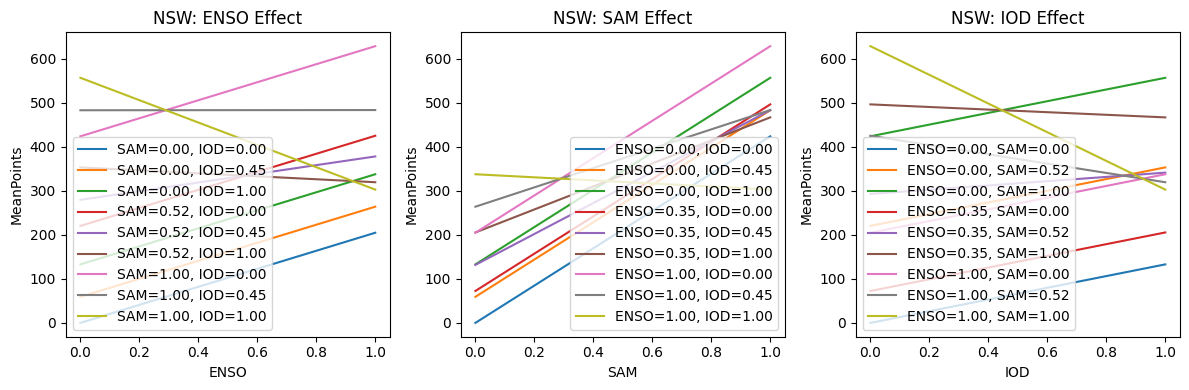

Partial Derivatives for QLD:
d(MeanPoints)/d(ENSO) = 94.30
d(MeanPoints)/d(SAM) = 17.58
d(MeanPoints)/d(IOD) = 12.80


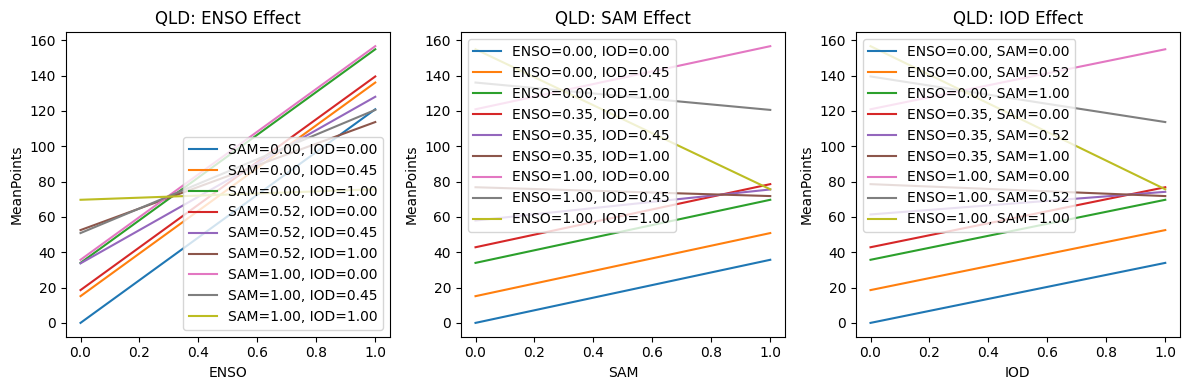

Partial Derivatives for VIC:
d(MeanPoints)/d(ENSO) = 40.12
d(MeanPoints)/d(SAM) = 315.21
d(MeanPoints)/d(IOD) = 51.32


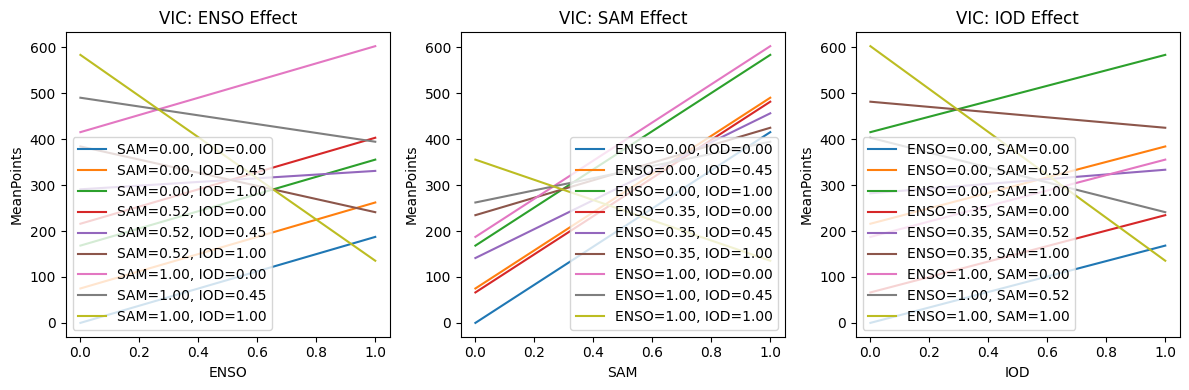

Partial Derivatives for WA:
d(MeanPoints)/d(ENSO) = -55.57
d(MeanPoints)/d(SAM) = 208.06
d(MeanPoints)/d(IOD) = 45.64


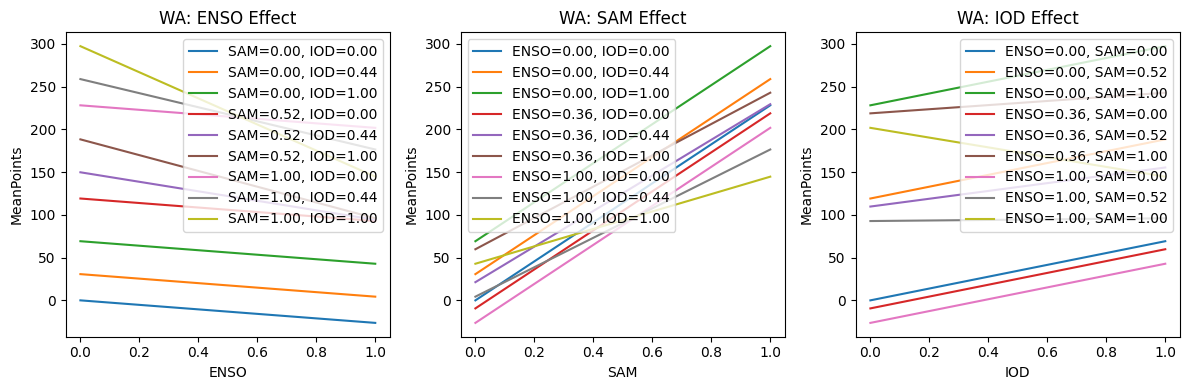

In [13]:

def analyze_interaction(state_name, model, X):
    # Extract coefficients
    b_enso = model.params['ENSO']
    b_sam = model.params['SAM']
    b_iod = model.params['IOD']
    b_interaction = model.params['ENSO_SAM_IOD']

    # Calculate partial derivatives
    d_enso = b_enso + b_interaction * X['SAM'].mean() * X['IOD'].mean()
    d_sam = b_sam + b_interaction * X['ENSO'].mean() * X['IOD'].mean()
    d_iod = b_iod + b_interaction * X['ENSO'].mean() * X['SAM'].mean()

    print(f"Partial Derivatives for {state_name}:")
    print(f"d(MeanPoints)/d(ENSO) = {d_enso:.2f}")
    print(f"d(MeanPoints)/d(SAM) = {d_sam:.2f}")
    print(f"d(MeanPoints)/d(IOD) = {d_iod:.2f}")

    # Slopes Analysis
    enso_range = np.linspace(X['ENSO'].min(), X['ENSO'].max(), 100)
    sam_range = np.linspace(X['SAM'].min(), X['SAM'].max(), 100)
    iod_range = np.linspace(X['IOD'].min(), X['IOD'].max(), 100)

    # Plot ENSO effect at different SAM and IOD levels
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    for sam in [X['SAM'].min(), X['SAM'].mean(), X['SAM'].max()]:
        for iod in [X['IOD'].min(), X['IOD'].mean(), X['IOD'].max()]:
            y = b_enso * enso_range + b_sam * sam + b_iod * iod + b_interaction * enso_range * sam * iod
            plt.plot(enso_range, y, label=f'SAM={sam:.2f}, IOD={iod:.2f}')
    plt.xlabel('ENSO')
    plt.ylabel('MeanPoints')
    plt.title(f'{state_name}: ENSO Effect')
    plt.legend()

    # Plot SAM effect at different ENSO and IOD levels
    plt.subplot(132)
    for enso in [X['ENSO'].min(), X['ENSO'].mean(), X['ENSO'].max()]:
        for iod in [X['IOD'].min(), X['IOD'].mean(), X['IOD'].max()]:
            y = b_enso * enso + b_sam * sam_range + b_iod * iod + b_interaction * enso * sam_range * iod
            plt.plot(sam_range, y, label=f'ENSO={enso:.2f}, IOD={iod:.2f}')
    plt.xlabel('SAM')
    plt.ylabel('MeanPoints')
    plt.title(f'{state_name}: SAM Effect')
    plt.legend()

    # Plot IOD effect at different ENSO and SAM levels
    plt.subplot(133)
    for enso in [X['ENSO'].min(), X['ENSO'].mean(), X['ENSO'].max()]:
        for sam in [X['SAM'].min(), X['SAM'].mean(), X['SAM'].max()]:
            y = b_enso * enso + b_sam * sam + b_iod * iod_range + b_interaction * enso * sam * iod_range
            plt.plot(iod_range, y, label=f'ENSO={enso:.2f}, SAM={sam:.2f}')
    plt.xlabel('IOD')
    plt.ylabel('MeanPoints')
    plt.title(f'{state_name}: IOD Effect')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Analyze NSW and QLD
for state_name in ['NSW', 'QLD', 'VIC', 'WA']:
    state = state_dfs[state_name]
    X = state[['ENSO', 'SAM', 'IOD']]
    y = state['MeanPoints']

    # Standardize the independent variables
    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

    # Create interaction terms
    X_scaled['ENSO_SAM_IOD'] = X_scaled['ENSO'] * X_scaled['SAM'] * X_scaled['IOD']

    # Add a constant to the model (intercept)
    X_scaled = sm.add_constant(X_scaled)

    # Fit the regression model
    model = sm.OLS(y, X_scaled).fit()

    analyze_interaction(state_name, model, X_scaled)

Partial derivatives showing the average effect of each climate index on MeanPoints, considering the interaction.
Plots showing how the relationship between MeanPoints and each climate index changes at different levels of the other two indices.
Interpreting the results:
- Partial Derivatives:
If positive, it means an increase in that index generally leads to higher MeanPoints.
If negative, it means an increase in that index generally leads to lower MeanPoints.
- Slopes Analysis Plots:
Each line represents the relationship between one climate index and MeanPoints at different fixed levels of the other two indices.
If the lines are not parallel, it indicates an interaction effect.
The steepness of the lines shows the strength of the effect.
By examining these results, you can determine:
The general direction of each climate index's effect on MeanPoints.
How these effects change under different conditions of the other indices.
Which combinations of high/low values for ENSO, SAM, and IOD lead to higher or lower MeanPoints.
This analysis will help you understand the complex interactions between these climate indices and their impact on MeanPoints in NSW and QLD.

Interpretation:
The different directions of the lines indicate that the effect of one climate index on MeanPoints changes depending on the values of the other indices. This is exactly what an interaction term captures - the idea that these climate patterns don't operate in isolation, but influence each other's effects.
For Queensland (QLD):
- In the IOD Effect chart: When SAM is high, the effect of IOD becomes more pronounced (steeper slope). This suggests that SAM amplifies the impact of IOD.
- In the SAM Effect chart: The direction of SAM's effect changes based on ENSO and IOD values. This indicates a complex three-way interaction.
- In the ENSO Effect chart: The impact of ENSO seems more consistent across different SAM and IOD values, but still shows some variation.
